# Purpose: to explore the BU projects to decide which data to include and omit from the training set. 
#### There are three splits of the data, and three or four categories of data to consider.

# Section A: Splits and datasets

1. The training data used to train the model. 
2. The validaion data used for evaluation of the model during training.
3. The test data used to evaluate the final model. This will be withheld during the training process.
The final model will be run on soundscape recordings, so the model needs to be evaluated on soundscape recordings.
In addition, the model will be trained on short audio clips, so part of the evaluation process will look at how the model is performing on these clips.



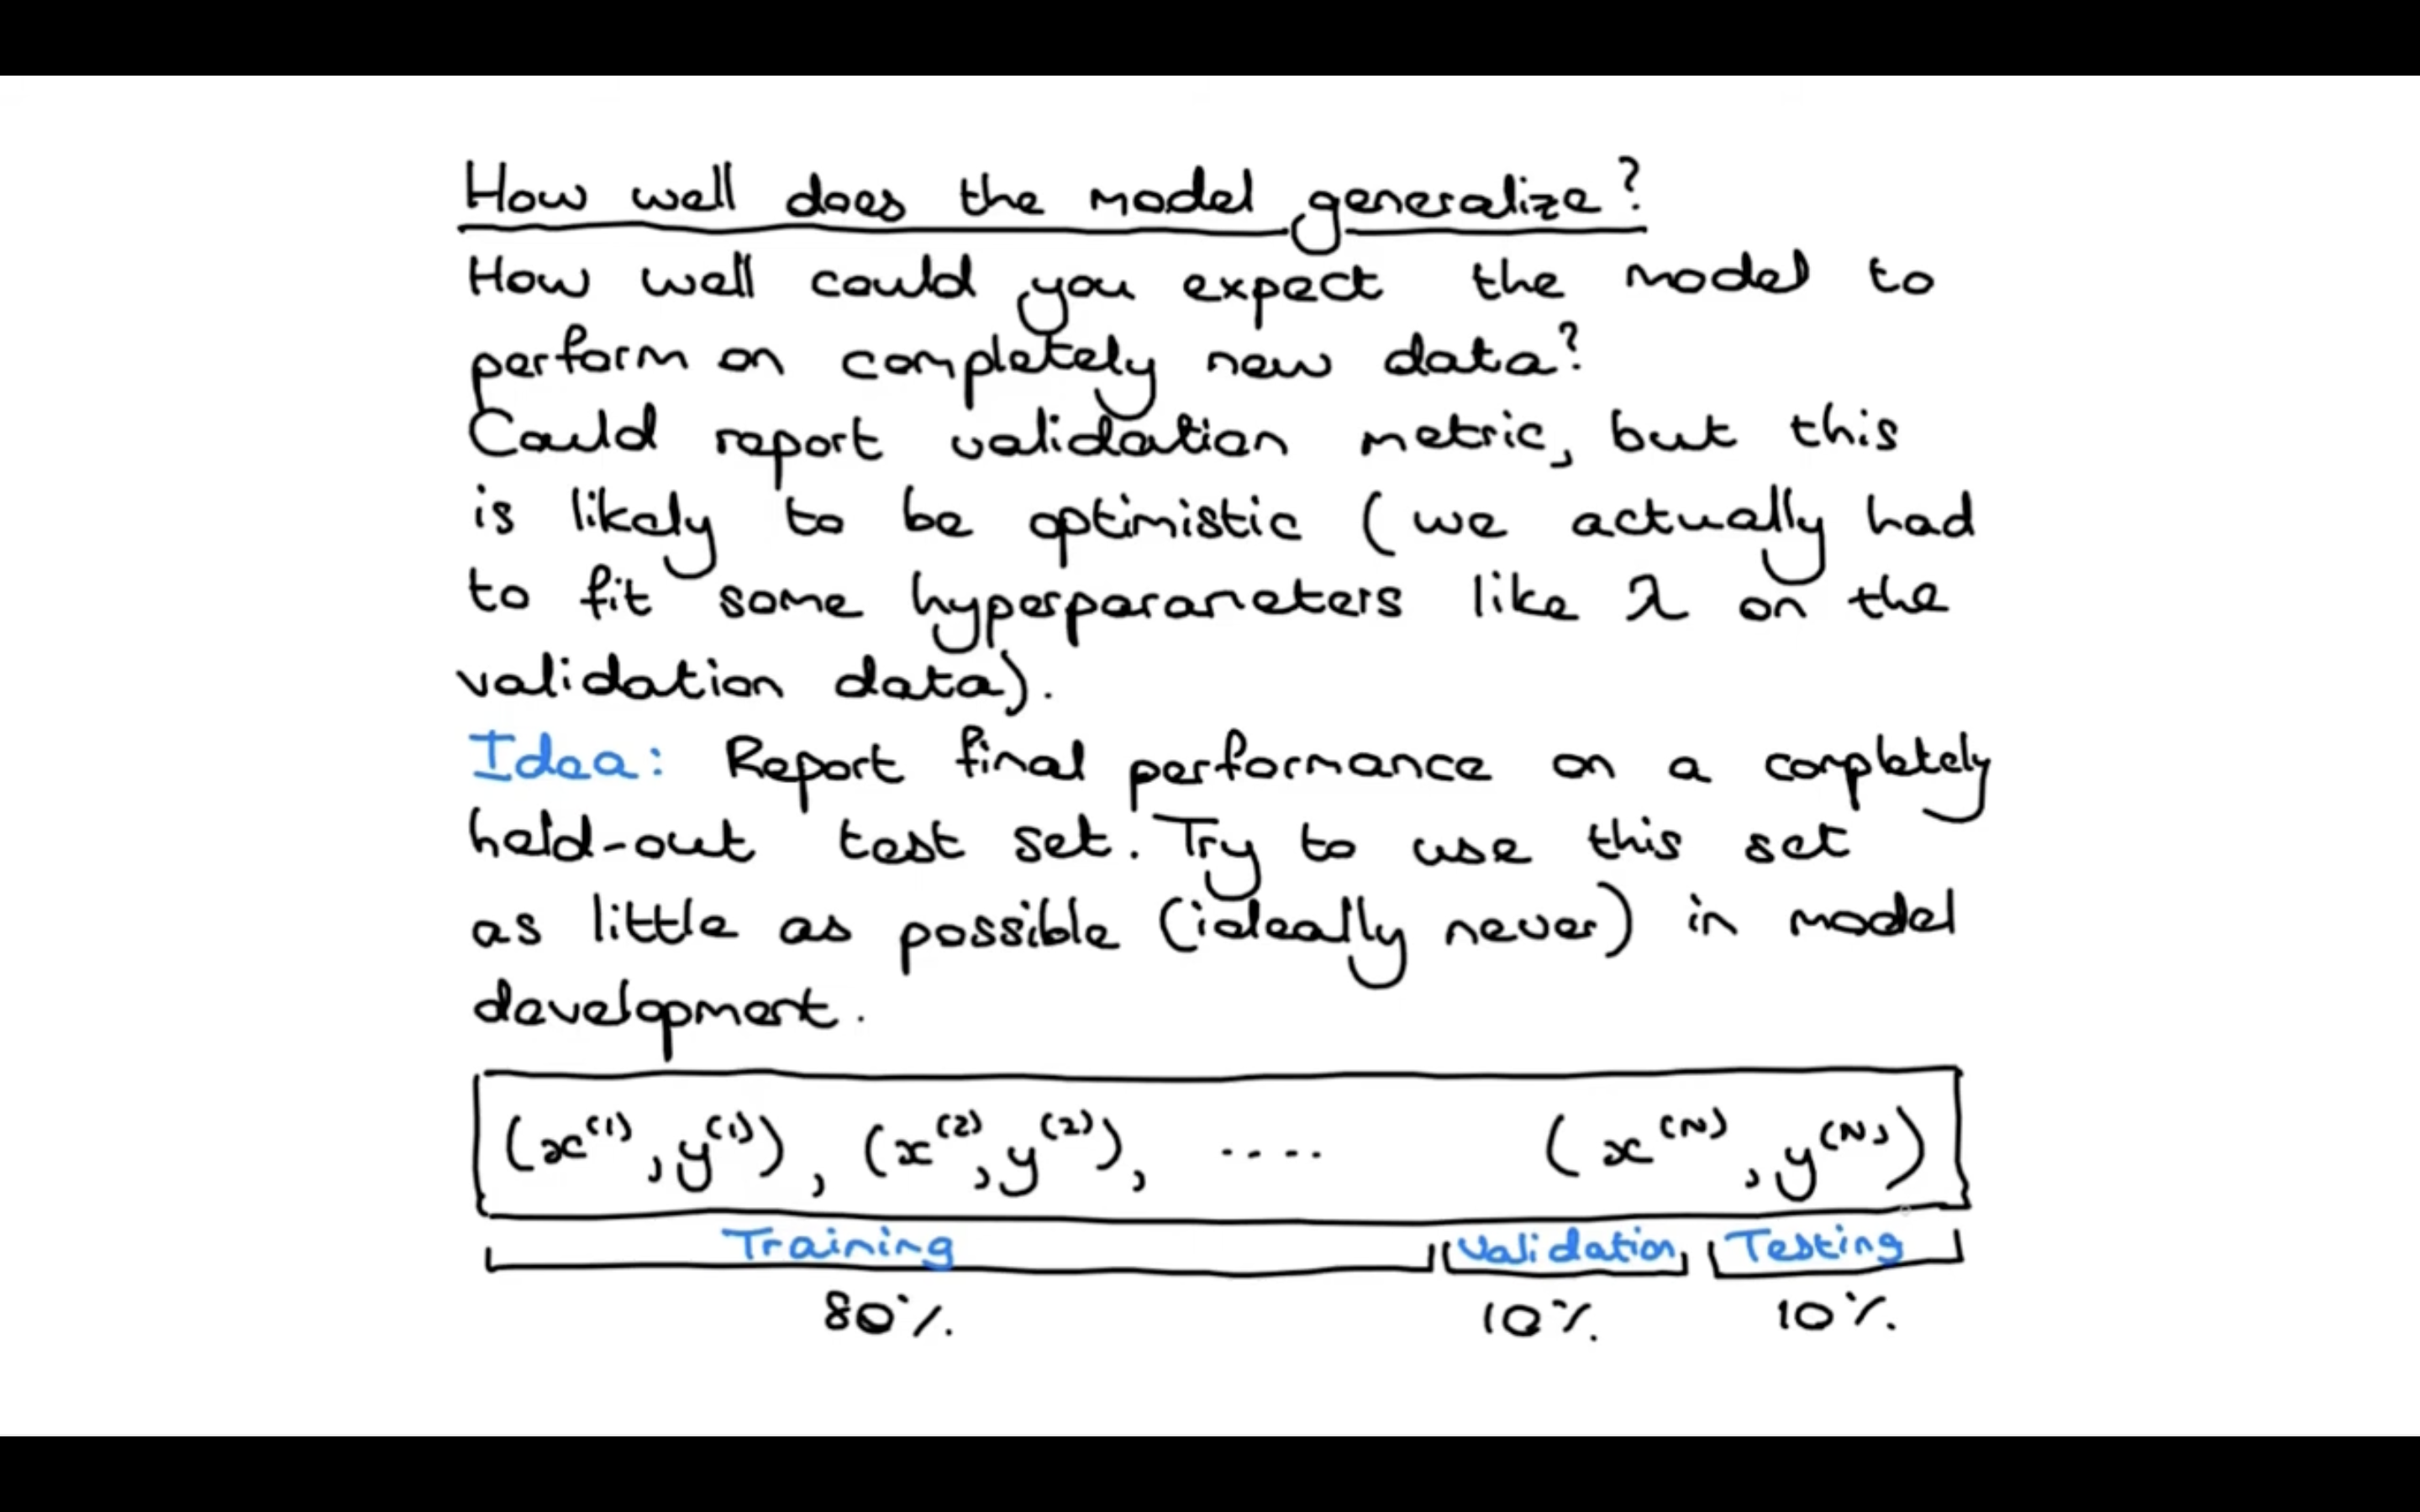

In [86]:
from IPython.display import Image
Image("./tvd.png")


### Proposed split options:
1. __Split the training, validation and test sets by ARU location ID.__
    This will have the advantage of making sure that the recordings all come from different locations, and so the model will not be overfit to the specifics of a particular location.
    <br>
2. __Split the training, validation and test sets by geographic area.__
    This will have the advantage of making sure that the recordings all come from different geographic regions, and so we may get an idea of how the model will generalize to other regions outside of the training area.<br>
3. __Randomly shuffle all the data and split into training, validation and test sets.__ This is the simplest method and will be used as a baseline.<br>
4. There are many more ways to split the data, by __date of recording__ we would get an idea of how the model performs on recent time windows, which could be relevant if the environmental noise or another factor is changing over time. 
If any of these options are chosen, the final use case of the model should be considered, in order to make sure that the final report is relevant to the use case.

|

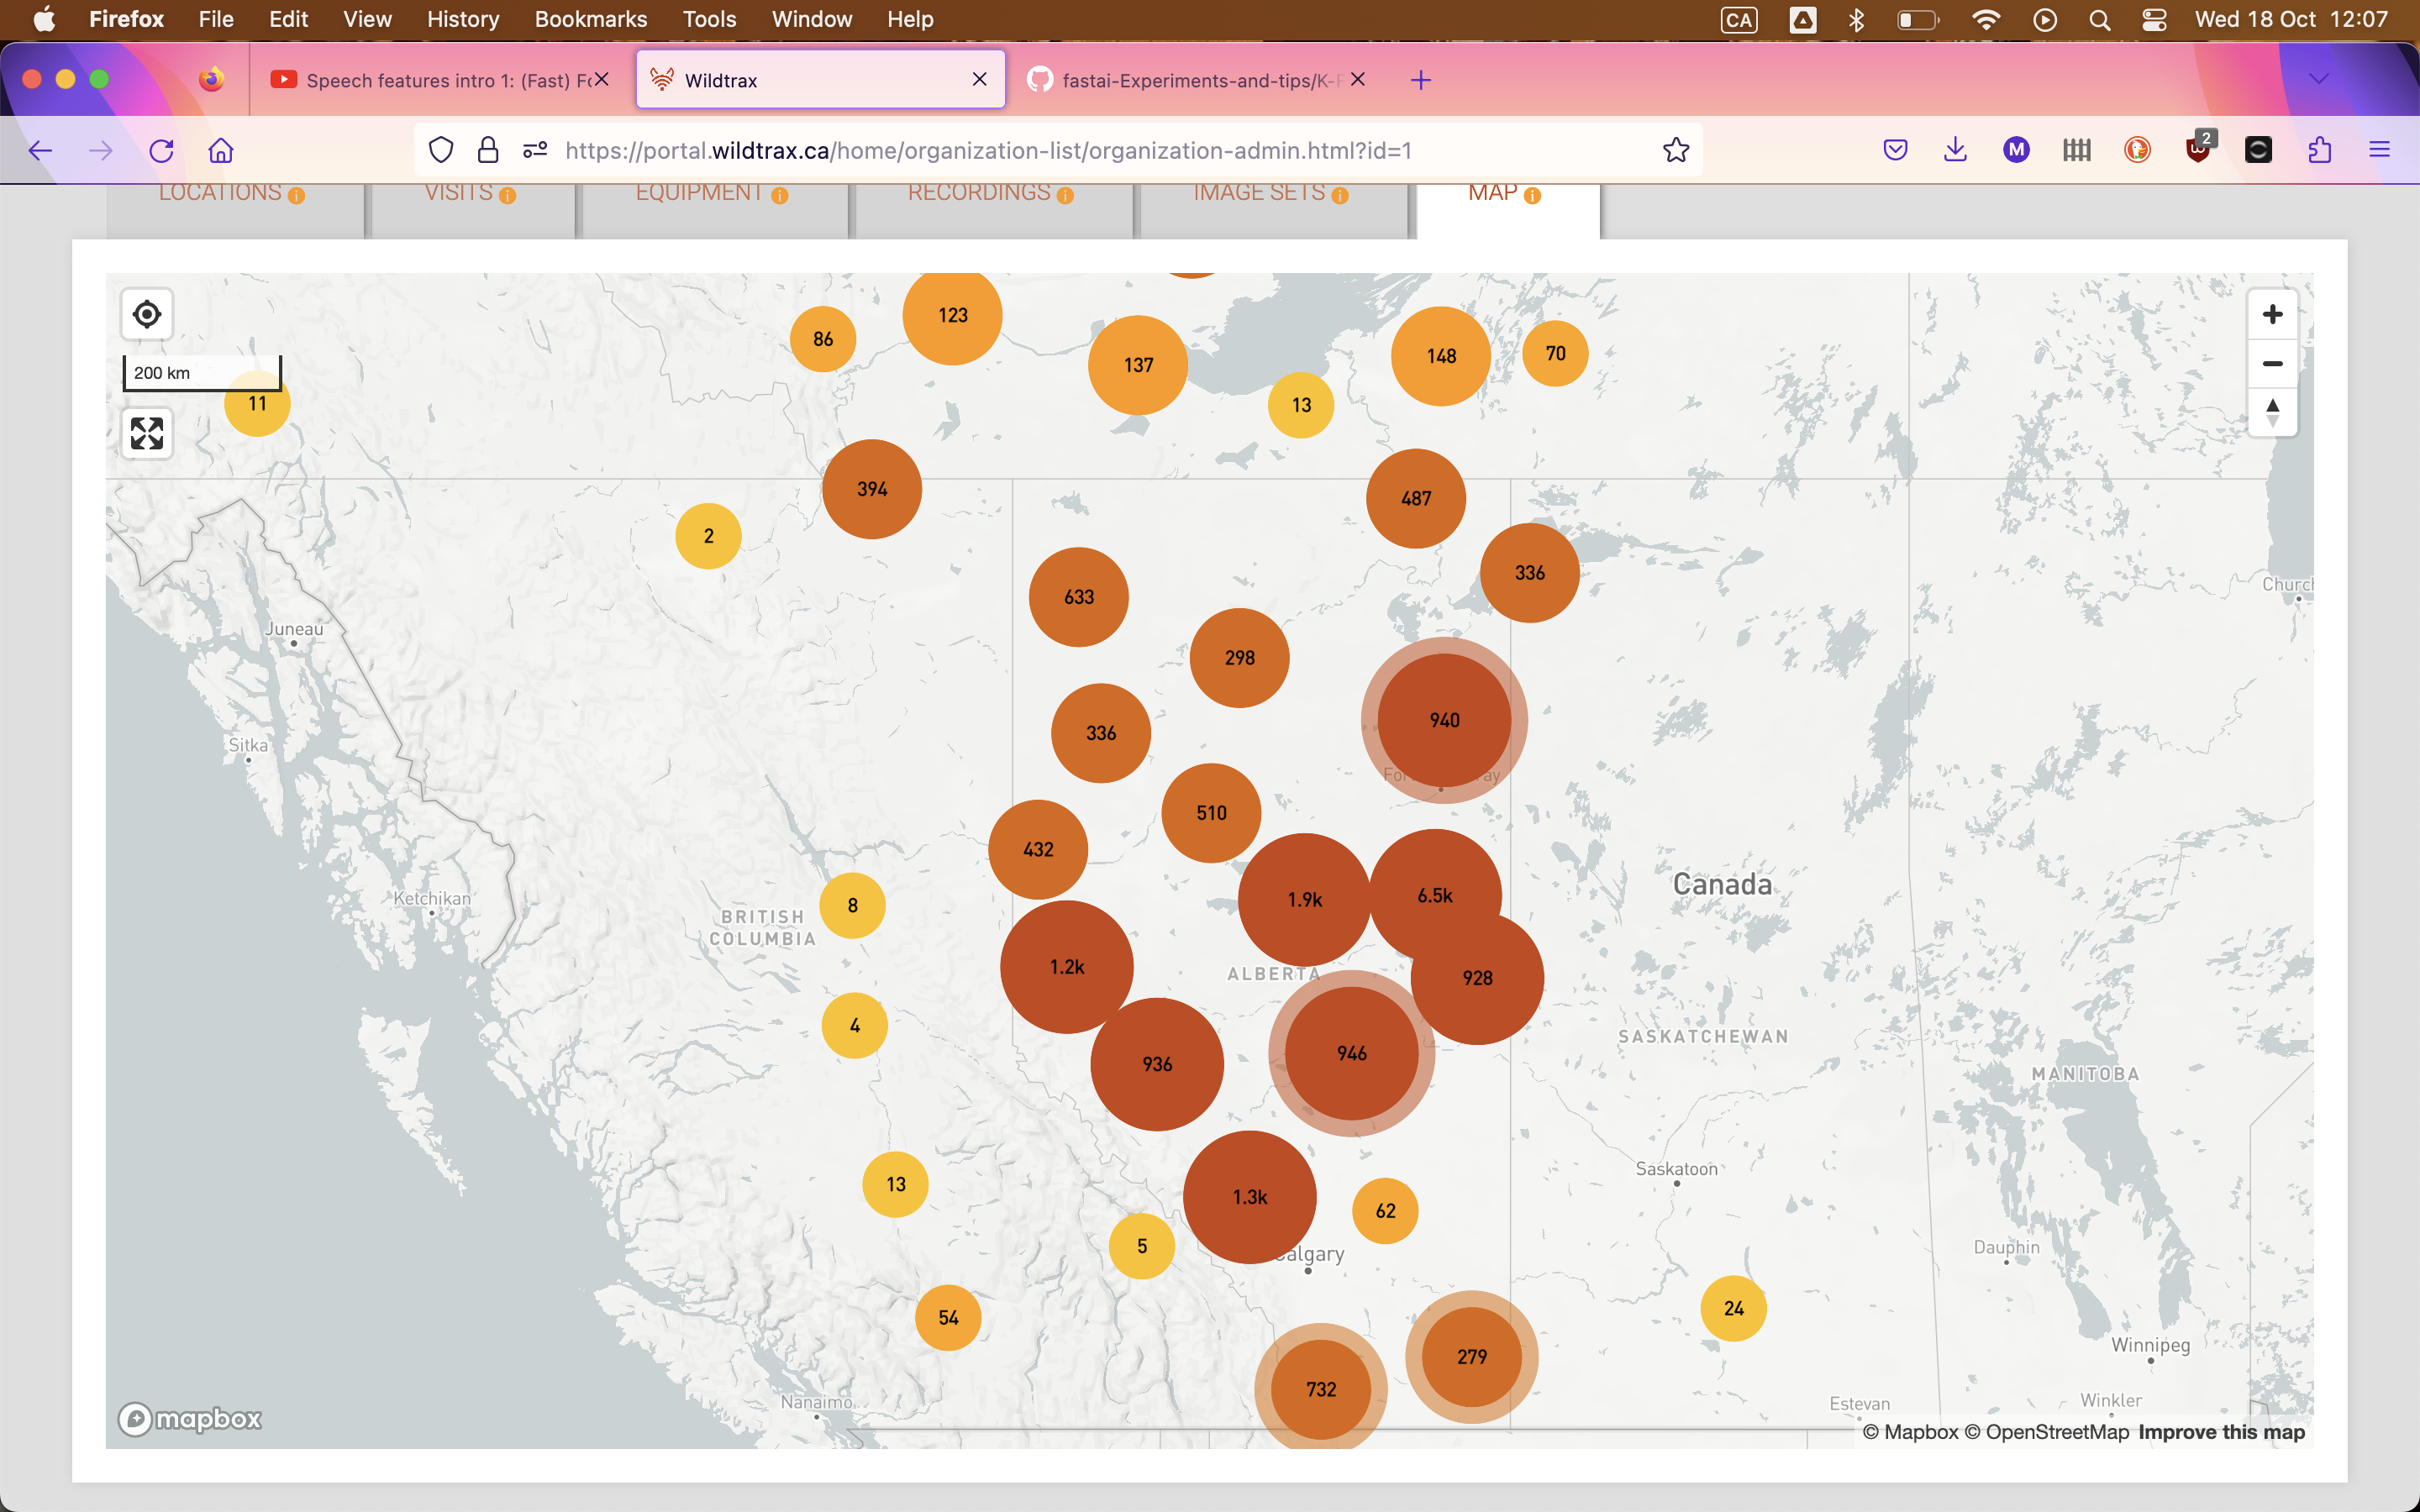

In [87]:
Image("./map.png")


### There will be three or four categories of data to consider:
1. Audio samples containing an olive sided flycatcher call:
This is relatively simple since we have a list of clips that contain the call in the training csv file. <br>

2. Audio samples of birds which are not the olive sided flycatcer:
This is also simple, since we have a list of tags for other bird species, but there is no guaruntee that there isn't an olive sided flycatcher in the background of one of these tags. 

3. What's the process for making a recording file? Are the recording ID's the same files which come off the ARU? Are they split into smaller chunks on the ARU and if so are these given different IDs or the same ID? 

These first two sets of data can be used to train an initial model by treating set 1 as calls, and set 2 as no-calls, but there is prior knowledge embedded in the training data: that a bird call is present in the recording. 


To make a no-call dataset, Elly proposed that I shoule aggregate by recording and pull negative data out of recordings that don't have OSFL in them.

    1. How can I be sure that people were listening for olives sided flycatchers in these recordings without osfl tags?
    2. make sure these recordings are from osfl habitat, and from projects which were looking for olive sided flycatchers.


To make a true 'no-call' data set, another step is proposed: take into account the tagging method used on WildTrax. There are two or three which I'm aware of:

- '1SPT' (one sample per time interval)
- '1SPM' (one sample per minute)
- no restrictions' (all of the vocalizations in the recording are tagged)


With this information, a recording ID, and the start and end time of an olive sided flycatcher clip, I can extract audio segments from before the first OSFL tag in a recording, and from segments of audio from between 60s, 120s (+n*60) and the start of an OSFL tag made within each minute.

A second source of true no-call could come from the recordings tagged with the 'no restrictions' tagging method, where there are no restrictions on the number of tags per recording. This could provide another denser source of true no-call data, but unfortunately the .csv file doesn't contain a label for 'no restrictions'. It may be that they were exported with the label 'None' instead but this is not clear.

These clips will have the advantage of containing periods of quiet, and the types of background noise associated with olive sided flycatcher habitat. 









### Questions to answer:

1. Having done some listening tagging in the past, is it an ok assumption that the audio between the time interval and the first tag is a 'no-call'? Or do people wait for a few calls then tag the call only once they're certain it was a species call?

2. Do you need the model to work on projects in areas from outside of the training area? Or do you want it to work on similar future projects in the same areas as the training data? Or both? This will affect my decsion of how to split the test data from the training data. I'm asking because the majority of the training data seems to come from Alberta. It might be worth looking for more data sources within BC.

3. I've been calling the vocalizations 'calls' rather than 'songs' - just realised.

4. 


# Section B - Data exploration

In [88]:
import pandas as pd
import sys
import os
from pathlib import Path
sys.path.append(os.path.abspath(os.path.join('..', '..')))

In [89]:
data_path = Path("../../data/")
df = pd.read_pickle(data_path / 'interim' / 'processed_metadata.pkl')

KeyboardInterrupt: 

### After the filtering operations performed in clean_csv.py, how many OSFL positive tags remain?

In [ ]:
osfl_count = sum(df.species_code == 'OSFL')
osfl_count

5184

In [ ]:
sum(df.file_type == 'flac')


271116

In [ ]:
sum(df.file_type == 'mp3')


274508

The distribution of osfl detections per project is shown below:

In [ ]:
df.loc[df['species_code'] == 'OSFL'].project.value_counts()

project
CWS-Ontario Birds of James Bay Lowlands 2021                     1752
CWS-Ontario Boreal Shield-Lowlands Transition 2022               1101
Boreal Wetland Community Monitoring                               698
Bayne-OSFL-BU-AnyYr 2021                                          301
Lebeuf-Taylor - BRCR, RCKI, OSFL, REVI, TEWA, YRWA - BU 2021      139
Lebeuf-Taylor - 2023 RETN                                         137
Big Grids                                                         125
Retention                                                          75
CWS-Ontario Birds of James Bay Lowlands 2021 (Resample)            75
Lebeuf-Taylor - 2021 RETN                                          71
Bioacoustic Unit Digital Point Counts                              57
CWS-Ontario Lake Superior NMCA 2021                                55
CWS-Ontario Incidental Atlas ARUs - 2022                           51
Natural Disturbance Long-term Monitoring Program 2016              46
Lebeuf-Taylo

In [ ]:
df.loc[df['species_code'] == 'OSFL'].project.value_counts()[:11].sum()/osfl_count

0.8740354938271605

# Where is most of the osfl call data coming from? 
Take a look through the 11 projects which return the most osfl calls. These account for 87% of the calls in the training set (after filtering)


### 1.  CWS-Ontario Birds of James Bay Lowlands 2021  
1101 samples
From wildtrax:
This is a public project. 
There were 8836 completed tasks and 188 resamples. 

What does resample mean? Could these be duplicates? If so these will need filtering out of the database. 

The 8836 dataset doesn't show up on the map - only the 188 resamples




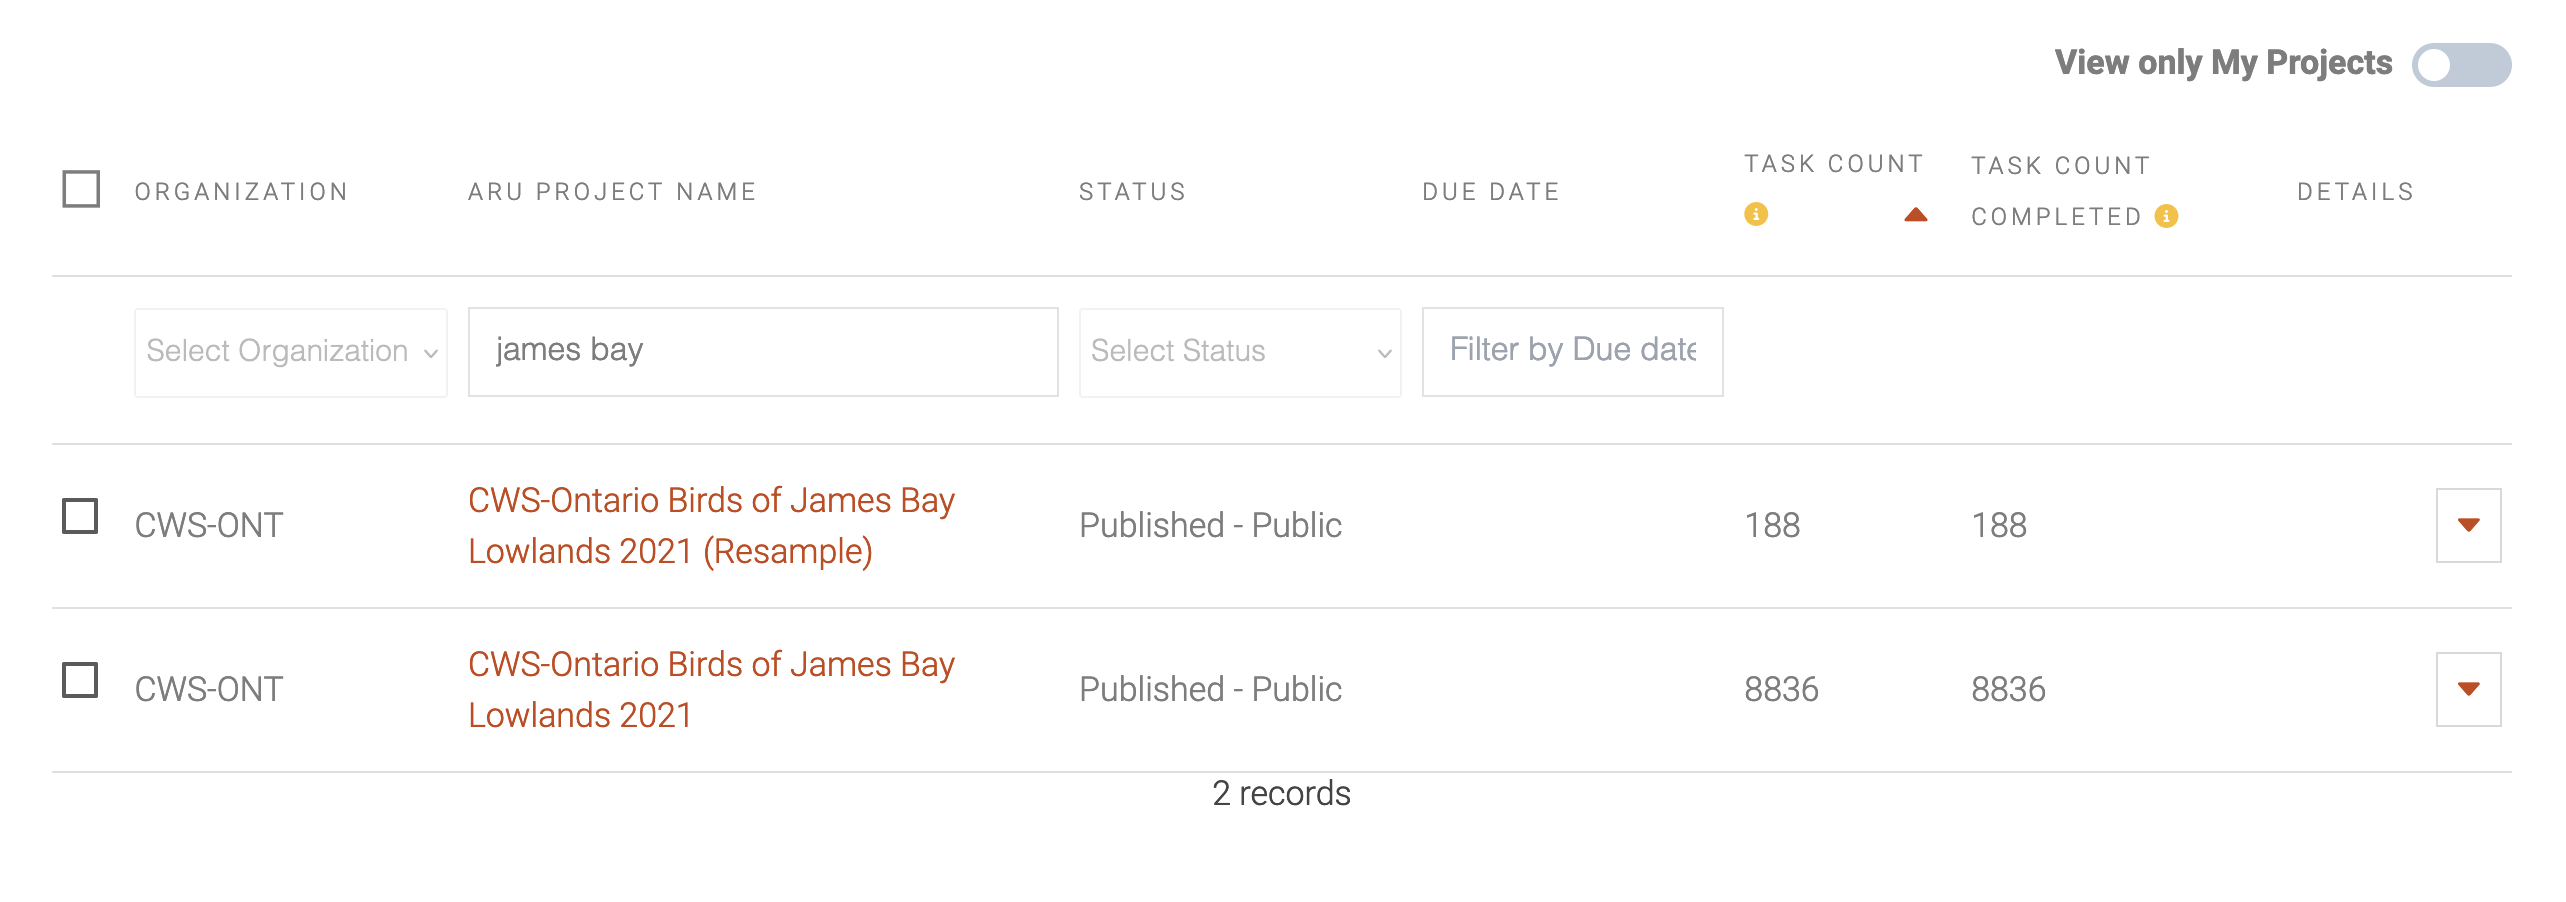

In [ ]:
Image('./jamesbay.png')

These are collected in Ontario. 

We might want to prefer recordings collected in BC or Alberta if these are closer to the final use case.

### 2. CWS-Ontario Boreal Shield-Lowlands Transition 2022               
1101 samples - from 172 ARU locations in Ontario



### 3. Boreal wetlands community monitoring 
   This is a long-term project that monitors wetlands across northern Alberta.
   698 osfl tags from this project across E - NE alberta. 
   

### 4. Bayne-OSFL-BU-AnyYr 2021 
- 301 oslf clips 
- contains calls from yukon and NW territories
- __details__:           OSFL - 4 visits to Emily sites.  Day 135 to 196. Hours 0 to 23 

### 5. Lebeuf-Taylor - BRCR, RCKI, OSFL, REVI, TEWA, YRWA - BU 2021
135 osfl clips from 698 recording locations all across Alberta

 __Details:__ Comparison project of occupancy and rate-of-use between residual legacy patches as single or aggregate of trees and clear-cut areas in harvest sites. Target species are Brown Creeper,Ruby-Crowned Kinglet, Olive-sided Flycatcher, Red-Eyed Vireo, Tennessee Warbler, and Yellow-Rumped Warbled (Myrtle). Each call or song for these species is tagged in 1 minute recordings. A 'none' tag is added if none of the target species are detected.
The audio data was obtained by the Bioacoustic Unit in both conifer and deciduous forests throughout Alberta during the 2021 breeding season.
Processing is ongoing by Isabelle Lebeuf-Taylor for her Master's thesis at the University of Alberta. Show Less

Note: Recordings from this 'none' tag can be used as no-call data. 

### 6. Lebeuf-Taylor - 2023 RETN
137 OSFL clips from 106 locations across N alberta and E of the rockies. 


### 7. Big Grids - this project produced 125 osfl samples. The project has ARUs all across alberta in grids: 
18 grids of 100 ARUs spaced 600 meters apart deployed in northeastern Alberta along a gradient of habitat and human footprint.

### 8. Retention 
This is a long-term project monitoring harvest practices across Alberta

### 9. CWS-Ontario Birds of James Bay Lowlands 2021 (Resample)
75 osfl calls. These should be discarded until it is confirmed that these aren't duplicated calls which  might end up in the database twice. This is the resample mentioned above. 


### 10. Lebeuf-Taylor - 2021 RETN
71 osfl tags, no description on wildtrax. Across alberta. 


### 11. Bioacoustic Unit Digital Point Counts
57 osfl samples. Taken from across alberta. 


Single visit recordings for 3 minutes at a non-predetermined locations within landscape clusters. Locations were extracted using a speech-to-text recognizer and assigned a value 'BUM (Bioacoustic Unit Mobile) - point number'. Locations were accessed using various linear features by ATV or on foot.



- The majority of the projects which make up the dataset are from Alberta. 
- Different data collection methods were used - some by ATV taking 3 minute recordings, others in regularly spaced grids and left out for multiple seasons. 

# Discussion 
From looking at the projects, it should be expected that the olive sided flycatcher calls in the dataset will be heavily biased to locations in alberta. It is possible that the data clustering is stronger than I have yet discovered  - within a project it is plausable that the majority of calls from a species come from a single or a handful of ARUs where the birds happened to nest close to that ARU. 

It is important to get a better handle on the location data and ARU ID for each clip. This will be done by generating a diversity report from each version of the dataset. 

Secondly, since the model is intended for use outside of Alberta, some training data from other provinces should be obtained. 


__Thoughts on dataset construction__

One of the design goals of the dataset is to include as much diversity as possible. 

Another design goal is to include no-song examples from the same ARU locations as the song examples.

If the osfl songs come from a small number of locations, then picking the non-song recordings would further decrease the diversity of locations the model is trained in. 

It is therefore important to choose no-song recordings both from ARU locations where osfl decections occured, and from where they did not occur. 

Let's start this now:

# Take a look at the data

In [ ]:
osfls_long = df.loc[df.species_code == 'OSFL']
osfls_long.columns

Index(['organization', 'project', 'project_id', 'location', 'location_id',
       'recording_date_time', 'recording_id', 'task_method', 'task_id',
       'aru_task_status', 'species_code', 'species_common_name',
       'species_scientific_name', 'species_class', 'detection_time',
       'task_duration', 'tag_duration', 'min_tag_freq', 'max_tag_freq',
       'tag_id', 'individual_order', 'vocalization', 'abundance', 'tag_rating',
       'tag_is_verified', 'clip_channel_used', 'observer', 'observer_id',
       'verifier_id', 'left_full_freq_tag_rms_peak_dbfs',
       'left_full_freq_tag_rms_trough_dbfs', 'left_full_freq_tag_pk_count',
       'left_full_freq_tag_dc_offset', 'left_full_freq_tag_min_level',
       'left_full_freq_tag_max_level', 'left_full_freq_tag_peak_level_dbfs',
       'left_freq_filter_tag_rms_peak_dbfs',
       'left_freq_filter_tag_rms_trough_dbfs', 'left_freq_filter_tag_pk_count',
       'left_freq_filter_tag_dc_offset', 'left_freq_filter_tag_min_level',
       'lef

In [ ]:
keep_cols = ['organization', 'project', 'project_id', 'location', 'location_id',
       'recording_date_time', 'recording_id', 'task_method', 'task_id',
       'aru_task_status', 'species_code', 'species_common_name',
       'species_scientific_name', 'species_class', 'detection_time',
       'task_duration', 'tag_duration', 'min_tag_freq', 'max_tag_freq',
       'tag_id', 'individual_order', 'vocalization', 'abundance', 'tag_rating',
       'tag_is_verified', 
       'verifier_id','media_url', 'clip_url', 'sensorId', 'tasks',
       'status', 'recording_url', 'file_type']

In [ ]:
osfls = osfls_long[keep_cols].copy() # Setting copy ensures the origianl df is not modified. 

In [ ]:
osfls.head(2)

organization                                  project  project_id  \
4420           BU  ARU Test Project Model Comparisons 2021        1099   
4470           BU  ARU Test Project Model Comparisons 2021        1099   

         location  location_id  recording_date_time  recording_id task_method  \
4420  ATP-FLB-14A       238593  2021-06-28 06:00:00        366621        1SPM   
4470  ATP-FLB-14A       238593  2021-07-02 05:00:00        366633        1SPM   

      task_id aru_task_status  ... tag_rating tag_is_verified verifier_id  \
4420   343288     Transcribed  ...        NaN               f          -1   
4470   343300     Transcribed  ...        NaN               f          -1   

                                              media_url  \
4420  https://portal.wildtrax.ca/home/aru-tasks/reco...   
4470  https://portal.wildtrax.ca/home/aru-tasks/reco...   

                                               clip_url  sensorId  tasks  \
4420  https://wildtrax-aru.s3.us-west-2.amazonaws.co...       ARU    212   
4470  https://wildtrax-aru.s3.us-west-2.amazonaws.co...       ARU    212   

      status                                      recording_url  file_type  
4420  Active  https://wildtrax-aru.s3.us-west-2.amazonaws.co...       flac  
4470  Active  https://wildtrax-aru.s3.us-west-2.amazonaws.co...       flac  

[2 rows x 33 columns]

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns


In [100]:
osfls.task_id.value_counts()[:5]

task_id
223998    38
231811    37
224949    33
231643    30
231640    27
Name: count, dtype: int64

In [101]:
osfls.tag_id.value_counts()[:5]

tag_id
2748897    1
3006474    1
3071659    1
2947163    1
2984693    1
Name: count, dtype: int64

What does the 'tasks' column describe? Tasks seems to be realted to project id since they have the same frequency couts. 

In [148]:
osfls.tasks.value_counts()[:5], osfls.project_id.value_counts()[:5]

(tasks
 8836     1752
 8060     1101
 20082     698
 365       301
 1713      139
 Name: count, dtype: int64,
 project_id
 885     1752
 1310    1101
 41       698
 787      301
 679      139
 Name: count, dtype: int64)

In [149]:
# the clip urls are all unique, so they don't need plotting. 
osfls.clip_url.value_counts()[:5].values

array([1, 1, 1, 1, 1])

In [150]:
### Some of the data makes sense to plot as histograms, whereas others are better visualized with a bar plot. Some columns don't make sense to plot at all.
hist_cols = ['detection_time', 'task_duration', 'tag_duration']
bar_cols = ['organization', 'project', 'project_id', 'location', 'location_id', 'recording_date_time', 'recording_id', 'task_method', 'task_id', 'aru_task_status', 'abundance', 'tag_rating', 'tag_is_verified', 'media_url', 'status', 'recording_url', 'file_type']

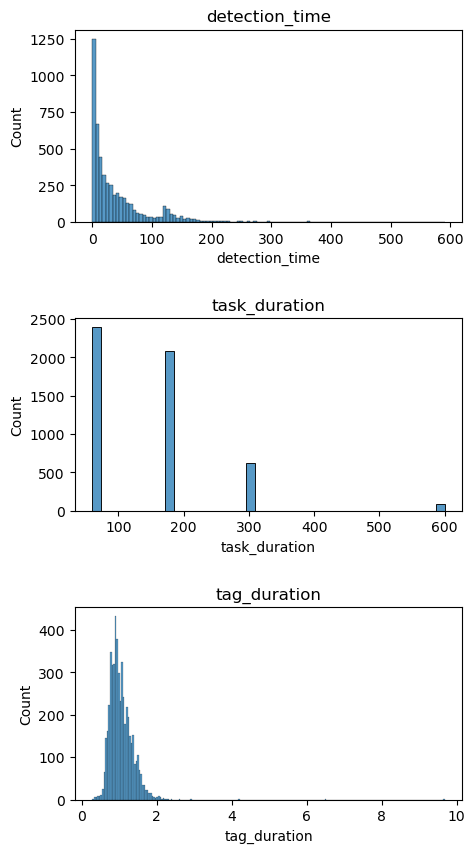

In [151]:
# Plot the histogram data in one plot
fig, axs = plt.subplots(3, 1, figsize=(5, 10))
for ax, col in zip(axs, hist_cols):
    ax.set_title(col)
    sns.histplot(osfls[col], ax=ax)
    plt.subplots_adjust(hspace=0.5)

In [152]:
len(bar_cols)

17

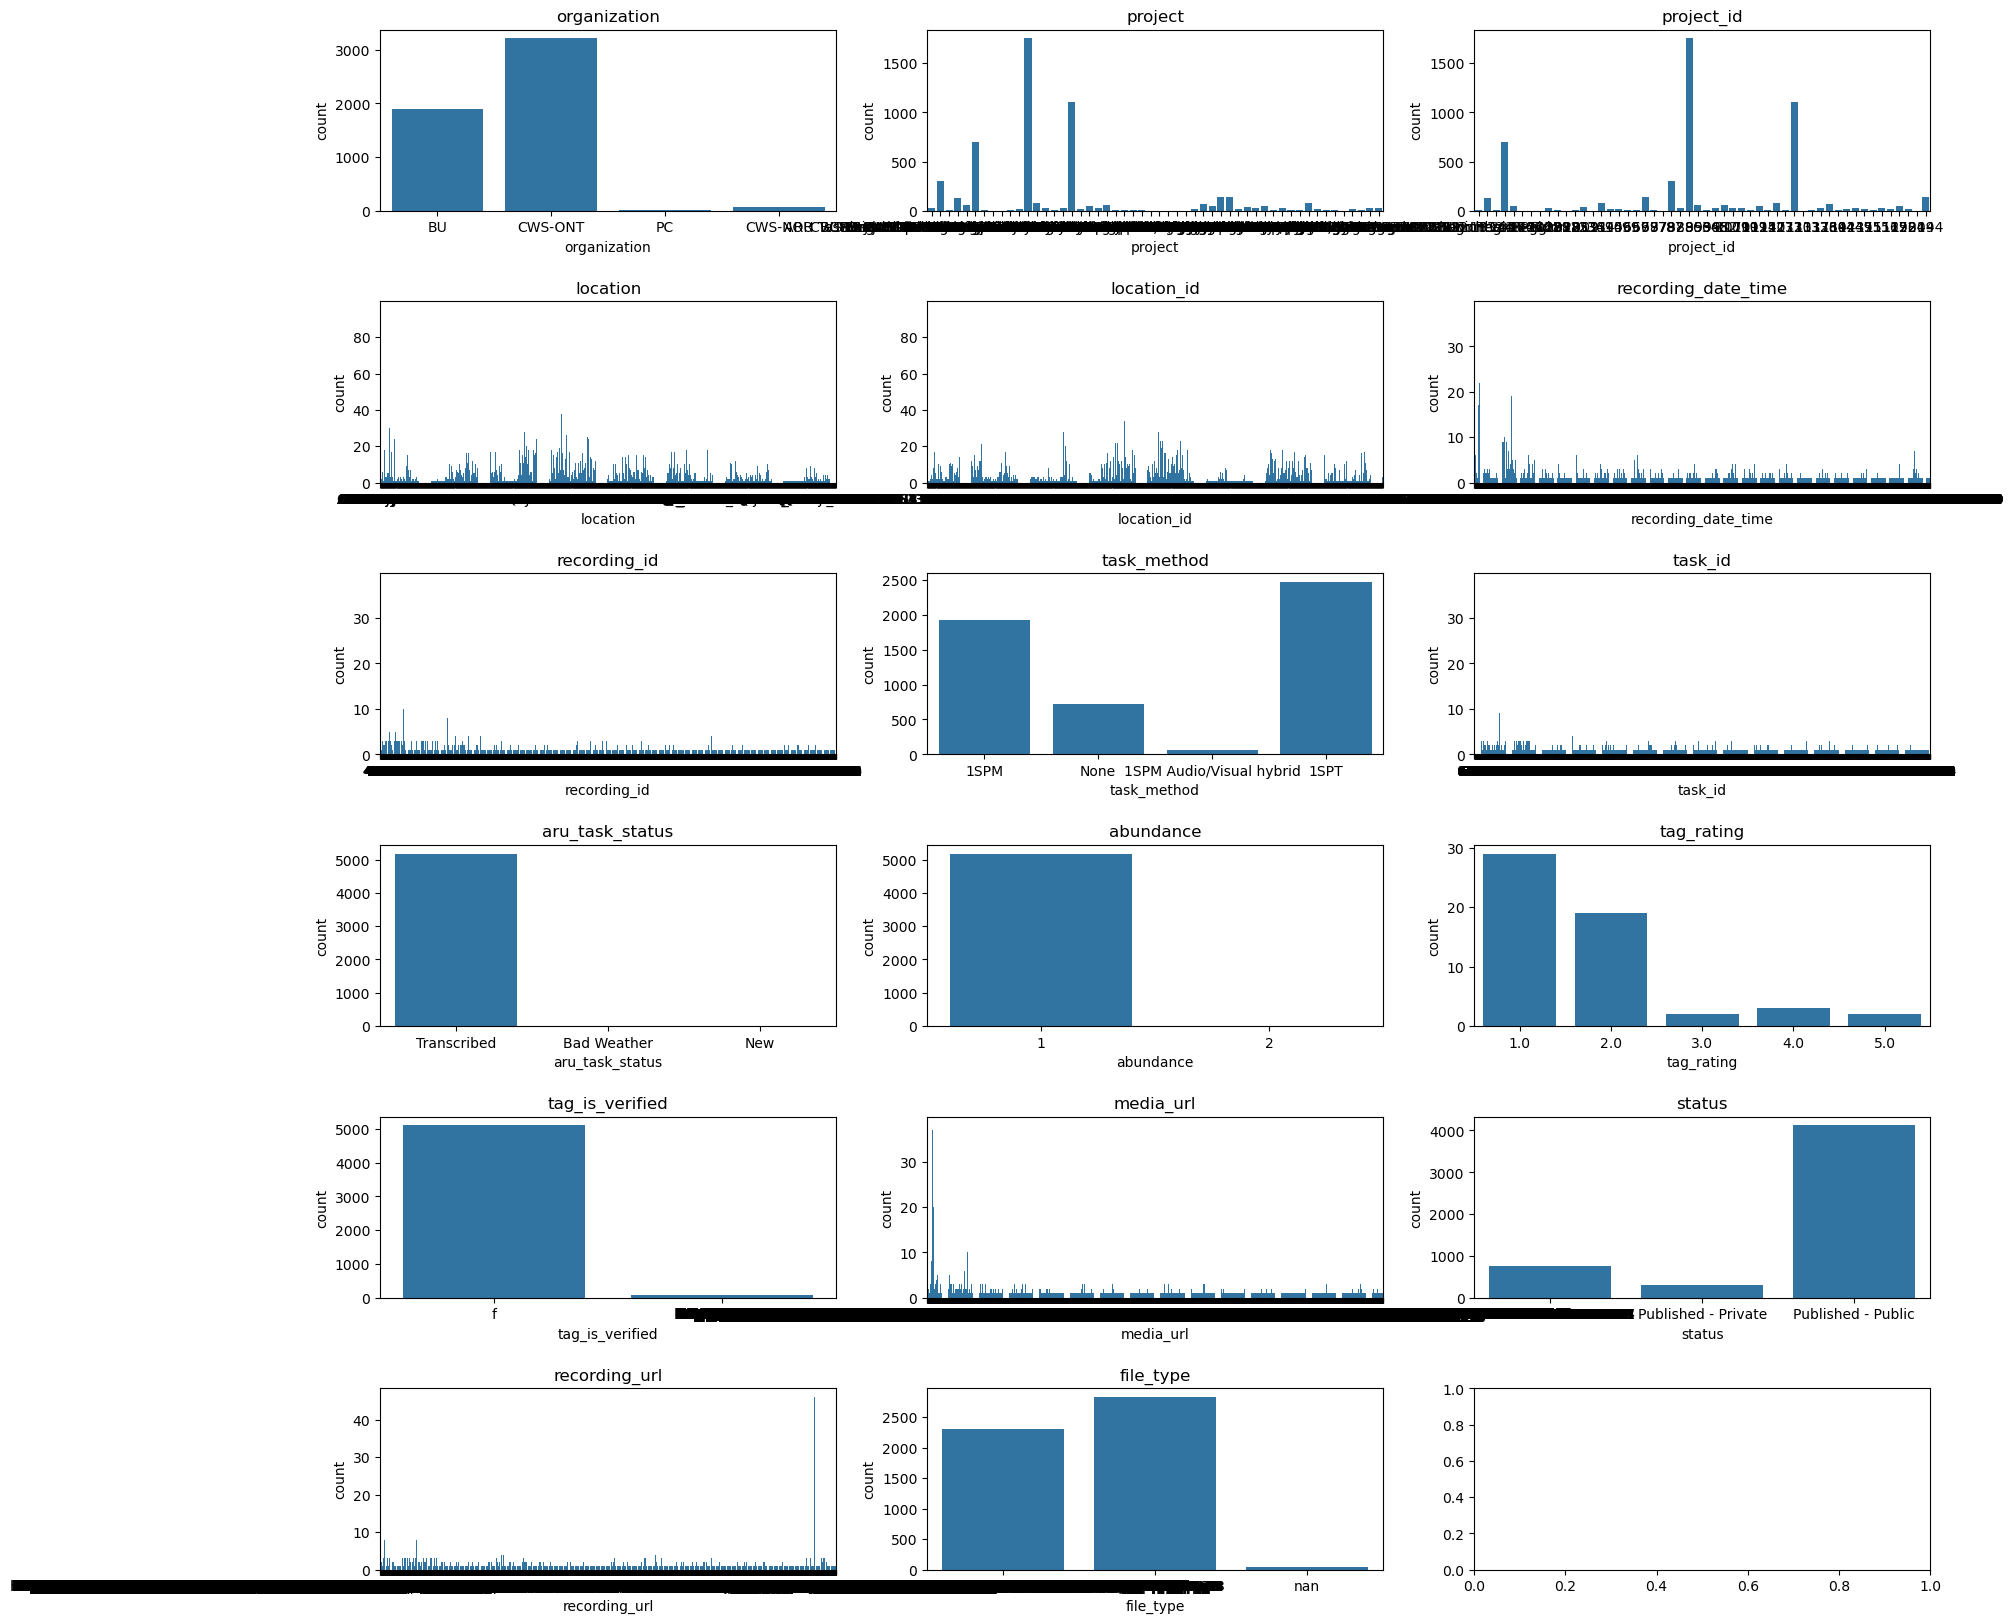

In [132]:
# plot the rest of the data in bar plots:
fig, axs = plt.subplots(6, 3, figsize=(20, 20))
for ax, col in zip(axs.ravel(), bar_cols):
    ax.set_title(col)
    sns.countplot(x=osfls[col], ax=ax)
    plt.subplots_adjust(hspace=0.5)



In [153]:
bar_cols_2 = ['project', 'project_id', 'location', 'location_id', 'recording_date_time', 'recording_id', 'task_id', 'media_url', 'recording_url']